In [38]:
# C嵊州高中
import concurrent.futures
import os
import random
import pandas as pd
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from datetime import datetime, timedelta
import numpy as np
from joblib import Parallel, delayed
#时间分析
import cProfile


class StudentAgent(Agent):
    def __init__(self, unique_id, model, class_id=None):
        super().__init__(unique_id, model)
        self.status = "S"  # 状态：S, E, I, Q，R
        self.roommates = []
        self.class_id = class_id  # 班级ID
        self.incubation_time = 0  # 潜伏期计时器
        self.infection_time = 0  # 感染时间计时器
        self.prev_status = "S"  # 初始化前一个状态为易感
        self.recovery_time = 0  # 恢复延时计时器

    def step(self):
        # 更新前一个状态
        self.prev_status = self.status

        # 同班接触、宿舍接触和随机接触
        if self.status == "I":
            if self.model.time_step in [0, 1, 6, 7, 12, 13, 18, 19]: # 当时间步为假期时
                self.random_contact2()  # 只进行随机接触
            else:
                self.class_contact()
                self.dorm_contact()
                self.random_contact()

        # 状态更新逻辑
        if self.status == "E":
            self.incubation_time += 1
            if self.incubation_time >= 1.5 and random.random() < 0.23:
                self.status = "I"
            elif self.incubation_time >= 3.5 and random.random() < 0.25:
                self.status = "S"
        elif self.status == "I":
            self.infection_time += 1
            if self.infection_time >= 3.5 and random.random() < 0.95:
                self.status = "R"
            elif self.infection_time >= 6 and random.random() < 0.05:
                self.status = "E"  # 回到E状态

        # 恢复状态逻辑
        elif self.status == "R":
            self.recovery_time += 1
            if self.recovery_time >= 15.625 and random.random() < 0.062:
                self.status = "E"
        return

    def class_contact(self):
        neighbors = self.model.schedule.agents 
        class_neighbors = [other for other in neighbors if other.class_id == self.class_id]  # 仅同班学生
        for _ in range(180):
            other = random.choice(class_neighbors)  # 随机选择一个班级内的同学
            if other != self and self.status == "I" and other.status == "S":
                if random.random() < 0.0069324:  # 一个感染者与一个易感者接触并导致该易感者感染的概率
                    other.status = "E"


    def dorm_contact(self):
        for _ in range(270):
            for roommate in self.roommates:
                if roommate != self and self.status == "I" and roommate.status == "S":
                    if random.random() < 0.0069324:
                        roommate.status = "E"

    def random_contact(self):
        contacts = random.choices(self.model.schedule.agents, k=150)
        for other in contacts:
            if other != self and self.status == "I" and other.status == "S":
                if random.random() < 0.0069324:
                    other.status = "E"

    def random_contact2(self):
        contacts = random.choices(self.model.schedule.agents, k=0)
        for other in contacts:
            if other != self and self.status == "I" and other.status == "S":
                if random.random() < 0.0069324:
                    other.status = "E"


class SchoolModel(Model):

    def __init__(self, N, initial_infected):
        super().__init__()
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(175, 175, True)
        self.data_collector = DataCollector(
            agent_reporters={"Status": "status"}
        )
        self.time_step = 1  # 设置开始日期
        self.start_date = datetime(2009, 9, 1)  # 初始化开始日期
        self.dates = []
        self.new_infections = []
        self.current_infections = []
        self.assign_dorms()
        self.initial_infected = initial_infected
        self.num_classes = 28

    def assign_dorms(self):
        dorms = [] 
        individuals_with_dorms = [agent for agent in self.schedule.agents if agent.has_dorm]

        def assign_dorm(individuals, size):
            dorm_mates = []
            for i in range(0, len(individuals), size):
                dorm_group = individuals[i:i + size]
                if len(dorm_group) == size:
                    for mate in dorm_group:
                        mate.roommates = dorm_group  # 将宿舍成员分配给每个学生
                    dorm_mates.append(dorm_group)
            return dorm_mates

        # 随机选择分配六人间还是八人间
        if random.choice([True, False]):  # 随机选择 True 或 False
            six_person_dorms = assign_dorm(individuals_with_dorms, 6)
            dorms.append(six_person_dorms)
        else:
            eight_person_dorms = assign_dorm(individuals_with_dorms, 8)
            dorms.append(eight_person_dorms)
            
        return dorms
            
    def step(self):
        new_infections_today = 0
        self.schedule.step()

        for agent in self.schedule.agents:
            if agent.status == "I" and agent.prev_status == "E":
                new_infections_today += 1

        self.new_infections.append(new_infections_today)

        # 更新日期
        self.time_step += 1
        self.dates.append(self.start_date + timedelta(days=len(self.dates)))
        self.data_collector.collect(self)

    def get_results(self):
        return pd.DataFrame({
            "Date":self.dates,
            "New Infections": self.new_infections
        })

    def run_single_model(self):
        # 重置模型
        self.schedule = RandomActivation(self)
        self.dates = []
        self.new_infections = []
        # 初始化学生代理
        for i in range(self.num_agents):
            class_id = i % 28
            selected_indices = np.random.choice(range(1419), size=616, replace=False)
            has_dorm =  i in selected_indices
            a = StudentAgent(i, self, class_id)
            self.schedule.add(a)
            self.grid.place_agent(a, (self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)))
            if i == 9:  # 只有第一个代理是感染者
                a.status = "I"

        # 模拟20天
        for _ in range(15):
            self.step()

        return self.new_infections, self.dates

    def run_model(self, **kwargs):
        num_runs = kwargs.get('num_runs', 1)  # 获取 num_runs 参数，如果不存在则默认为 1
        all_results = Parallel(n_jobs= 1 )(delayed(self.run_single_model)() for _ in range(num_runs))
        all_results_list = [result[0] for result in all_results]
        dates = all_results[0][1]

        # 创建结果DataFrame
        results_df = pd.DataFrame(all_results_list).T
        results_df.columns = [f'Run {i + 1}' for i in range(num_runs)]
        results_df['Date'] = [i for i in range(1, len(dates) + 1)]
        results_df = results_df.set_index('Date')

        print(results_df)
        results_df.to_csv("C_200.csv", index=False)


if __name__ == "__main__":
    model = SchoolModel(1419, initial_infected=1)
    model.run_model(num_runs=200)  # 指定循环次数
#     cProfile.run('model.run_model(num_runs=10)','heyue_A_hzc_joblib.prof')

    # 分析prof
# import pstats
# p=pstats.Stats('heyue_A_hzc.prof')
# p.strip_dirs()
# p.sort_stats('tottime').print_stats(10)

      Run 1  Run 2  Run 3  Run 4  Run 5  Run 6  Run 7  Run 8  Run 9  Run 10  \
Date                                                                          
1         0      0      0      0      0      0      0      0      0       0   
2         0      0      1      1      1      0      0      0      0       0   
3         0      1      0      1      2      0      0      0      0       1   
4         0      0      0      1      0      1      2      5      0       0   
5         5      1      2      0      3      1      1      0      2       1   
6         3      0      3      5      2      5      2      3      1       0   
7         0      2      3      4      7      2      1      3      1       2   
8         1      6      3      7      9      4      2      7      1       1   
9         3      3      6      7     10      6     13      7      4       1   
10        6      5      8     14      8      6      2     13      5       1   
11       13      7     14     22     21     14      

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


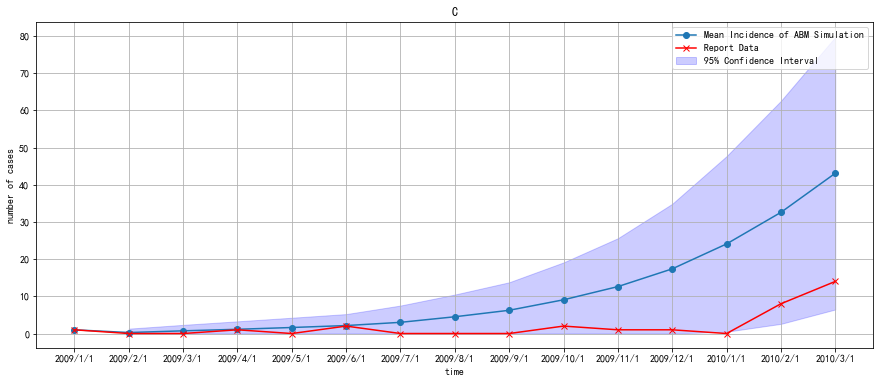

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

# 读取主要数据
data = pd.read_csv('C:/Users/Administrator/Desktop/C_1000.csv', header=0)

# 读取报告数据
report_data = pd.read_csv('C:/Users/Administrator/Desktop/report_C.csv', header=0)  # 根据需要调整header

# 初始化存储均值和可信区间的列表
means = []
conf_intervals = []

# 计算均值和95%可信区间
for i in range(data.shape[0]):  
    row = data.iloc[i]
    mean = np.mean(row)
    std = np.std(row)  # 计算样本标准差
    sem = stats.sem(row)  # 标准误差
    conf_interval = stats.t.interval(0.95, len(row), loc=mean, scale=std)
    
    means.append(mean)
    conf_intervals.append(conf_interval)

# 转换为numpy数组以方便计算
means = np.array(means)
means[0] = 1 
conf_intervals = np.array(conf_intervals)

# 计算可信带
lower_bound = conf_intervals[:, 0]
upper_bound = conf_intervals[:, 1]
lower_bound[lower_bound < 0] = 0
    
# 绘制均值折线图和可信带
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Times New Roman']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.figure(figsize=(15, 6))
plt.plot(report_data['time'].iloc[0:len(means)+1].values, means, marker='o', label='Mean Incidence of ABM Simulation')
plt.fill_between(range(len(means)), lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')

# 绘制报告数据的红色折线图
plt.plot(report_data['report'].iloc[0:].values, color='red', marker='x', label='Report Data')  # 替换为正确的列名
# plt.plot(report_data['simulate'].iloc[1:].values, color='b', marker='*',linestyle='--', label='拟合数据')

# 添加图例和标签
plt.title('C')
plt.xlabel('time')
plt.ylabel('number of cases')
plt.legend()
plt.grid()
plt.savefig('C:/Users/Administrator/Desktop/C_simulation_plot.png', dpi=200, bbox_inches='tight') 
plt.savefig('C:/Users/Administrator/Desktop/C_simulation_plot.pdf', dpi=200, bbox_inches='tight') 
plt.show()